# Fine Tuning Llama 3.2 1B for Question Answering

In [1]:
%%capture
!pip install -U transformers peft bitsandbytes datasets trl evaluate bert_score

In [2]:
from huggingface_hub import notebook_login
notebook_login()

## Data Preparation



In [3]:
import torch
print("GPU available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

GPU available: True
GPU device name: NVIDIA A100-SXM4-40GB


In [ ]:
from datasets import load_dataset

ds = load_dataset("azizmatin/question_answering")
# let's get some stats on the dataset
print(ds)

In [5]:
# Get the actual sizes of your datasets
train_size = len(ds['train'])
validation_size = len(ds['validation'])

print(f"Original train size: {train_size}")
print(f"Original validation size: {validation_size}")

# Set aside some data for testing
test_ratio = 0.1  # 10% for test
num_test_samples = int(train_size * test_ratio)

# Use the rest for training
num_training_samples = train_size - num_test_samples

# Use all of the validation set
num_validation_samples = validation_size

# Split the datasets
training_samples = ds['train'].select(range(num_training_samples))
test_samples = ds['train'].select(range(num_training_samples, train_size))
validation_samples = ds['validation']

print(f"Training samples: {len(training_samples)}")
print(f"Test samples: {len(test_samples)}")
print(f"Validation samples: {len(validation_samples)}")

Original train size: 9008
Original validation size: 930
Training samples: 8108
Test samples: 900
Validation samples: 930


In [6]:
from transformers import AutoTokenizer
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [7]:

def convert_squad_sample_to_llama_conversation(sample):
    # get the question and context for this sample
    question = sample['question']
    context = sample['context']

    # some questions can have multiple answers, some none at all,
    # for the case of no answers we'll have the model output that the
    # context does not provide an answer, if it has multiple we'll just take
    # the first answer as the ground truth.
    answers = sample['answers']['text']
    if len(answers) == 0 :
      answer = "The context does not provide an answer..."
    else:
      answer = sample['answers']['text'][0]

    # now we define an initial model prompt defining the task and giving the model the context passage
    instruction_prompt_template = '''
    You are a helpful assistant tasked with extracting passages that answer users questions from a given context. Output exact passages word for word that answer the users question. Do not output any other text other than passages in the context passage. Output the minimal amount to answer the question, for example only 2-3 words from the passage. If you cannot find the answer in the context passage output 'The context does not provide an answer...'

    Context: {context}'''

    # now we'll convert these into a list of messages for our conversation
    messages = [
        {"role": "system", "content": instruction_prompt_template.format(context=context)},
        {"role": "user", "content": question},
        {"role": "assistant", "content": answer}
    ]
    # apply the chat template and return the sample
    # we'll also return the single answer we expect and the list of messages without
    # the chat template in case we need them later.
    sample_conversation = tokenizer.apply_chat_template(messages, tokenize=False)
    return {"text": sample_conversation, "messages": messages, "answer": answer}

In [8]:
conversation_training_samples = training_samples.map(convert_squad_sample_to_llama_conversation)
conversation_test_samples = test_samples.map(convert_squad_sample_to_llama_conversation)
conversation_validation_samples = validation_samples.map(convert_squad_sample_to_llama_conversation)


Map:   0%|          | 0/8108 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/930 [00:00<?, ? examples/s]

## Model Preparation


In [9]:
from transformers import AutoTokenizer
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token

In [10]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

# to help save on gpu space and run this a bit faster we'll load the model in 4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    device_map="auto"
)
model.config.pad_token_id = tokenizer.pad_token_id

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [11]:
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

In [12]:
from peft import LoraConfig

rank = 16

peft_config = LoraConfig(
    r=rank,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['q_proj', 'v_proj', 'k_proj', 'o_proj'],
)

## Training

In [13]:
from transformers import TrainingArguments
from trl import SFTTrainer

# Define the model repository name
model_name = "llama3.2-1B-persianQAV2.0"

# Define the model checkpoint path
model_checkpoint_path = "./model/checkpoints"

# Update TrainingArguments
training_arguments = TrainingArguments(
    output_dir=model_checkpoint_path,
    optim='adamw_torch',
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    log_level='info',
    eval_strategy="steps",
    save_strategy="steps",
    logging_steps=100,
    eval_steps=100,
    save_steps=100,
    learning_rate=1e-5,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    weight_decay=0.05,
    max_grad_norm=0.3,
    fp16=True,
    num_train_epochs=3,
    warmup_ratio=0.15,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
    lr_scheduler_type='cosine',
    gradient_checkpointing=True,
    push_to_hub=True,
    hub_model_id=model_name
)

# Initialize the trainer without early stopping
trainer = SFTTrainer(
    model=model,
    train_dataset=conversation_training_samples,
    eval_dataset=conversation_test_samples,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/8108 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:401: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Using auto half precision backend


In [14]:
trainer.model.print_trainable_parameters()

trainable params: 3,407,872 || all params: 1,239,222,272 || trainable%: 0.2750


In [15]:
initial_eval_values = trainer.evaluate()
print(initial_eval_values)
initial_eval_loss = initial_eval_values['eval_loss']


***** Running Evaluation *****
  Num examples = 900
  Batch size = 8


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': 3.8302924633026123, 'eval_model_preparation_time': 0.003, 'eval_runtime': 103.6966, 'eval_samples_per_second': 8.679, 'eval_steps_per_second': 1.09}


In [16]:
trainer.train()

***** Running training *****
  Num examples = 8,108
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 8
  Total optimization steps = 1,518
  Number of trainable parameters = 3,407,872
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered inter

Step,Training Loss,Validation Loss,Model Preparation Time
100,3.727700,3.542244,0.003000
200,3.197400,2.802177,0.003000
300,2.599500,2.556452,0.003000
400,2.507500,2.516653,0.003000
500,2.473400,2.495822,0.003000
600,2.454700,2.482305,0.003000
700,2.430800,2.472114,0.003000
800,2.419100,2.464871,0.003000
900,2.416200,2.459256,0.003000
1000,2.403300,2.455852,0.003000



***** Running Evaluation *****
  Num examples = 900
  Batch size = 8


Saving model checkpoint to ./model/checkpoints/checkpoint-100
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000

TrainOutput(global_step=1518, training_loss=2.5717816183218374, metrics={'train_runtime': 4589.0558, 'train_samples_per_second': 5.3, 'train_steps_per_second': 0.331, 'total_flos': 7.390301959417037e+16, 'train_loss': 2.5717816183218374, 'epoch': 2.9965466206216083})

## Plotting the Loss


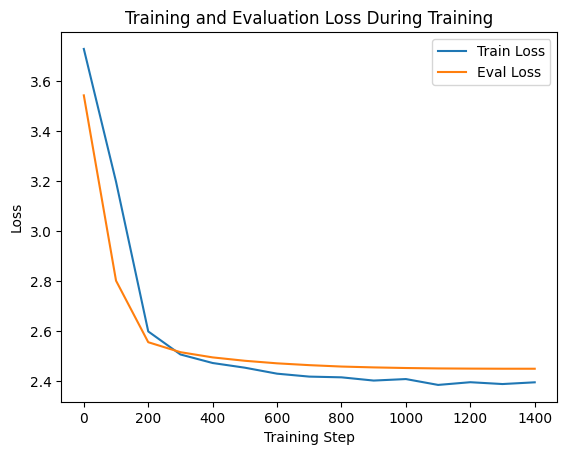

In [20]:
# Initialize lists before training
training_loss_history = []
eval_loss_history = []

# After each step, check for 'loss' and 'eval_loss' keys
for log_entry in trainer.state.log_history:
    if "loss" in log_entry:
        training_loss_history.append(log_entry["loss"])
    if "eval_loss" in log_entry:
        eval_loss_history.append(log_entry["eval_loss"])

# Adjust time steps based on logging frequency (e.g., every 50 steps)
time_steps = [i * 100 for i in range(len(training_loss_history))]
eval_time_steps = [i * 100 for i in range(len(eval_loss_history))]

# Plotting
import matplotlib.pyplot as plt

plt.plot(time_steps, training_loss_history, label="Train Loss")
plt.plot(eval_time_steps, eval_loss_history, label="Eval Loss")
plt.title("Training and Evaluation Loss During Training")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Saving the Trained Adapter


In [21]:
# saving the final model weights
final_model_path = "model/final_model"
trainer.save_model(final_model_path)

Saving model checkpoint to model/final_model
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_e

In [22]:
# move the model to the cpu and then delete the model, tokenizer and trainer objects
model.cpu()
del model, tokenizer, trainer
# We'll also call python to garbage collect any resources that might
# still be hanging around, and we'll clear the cuda cache.
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

## Loading The Model and Trained Adapters


In [23]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
import torch
final_model_path = "./model/final_model"
model_name = "meta-llama/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

# first we'll load in the base model
# to help save on gpu space and run this a bit faster we'll load the model in 4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="cuda")

# next we'll add our trained adapter to the model
model.load_adapter(final_model_path, adapter_name="adapter")

# now using enable_adapters and disable_adapters we can choose
# if we want to run inference on the model itself or have it be
# influenced by our newly trained weights
model.enable_adapters()

# also make sure we set the pad token, and for good measure turn off caching
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

# last we wrap the model in a hugging face pipeline for text-generation
# this helps streamline our inference code a bit by managing the inputs/outputs for us
model_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/tokenizer.json
loading file tokenizer.model from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
 

## Evaluation



In [24]:
from evaluate import load
import torch

# Switch to a smaller but still effective model
bert_model = "microsoft/deberta-base-mnli"  # Much less memory intensive
bertscore = load("bertscore")
exact_match_metric = load("exact_match")

In [25]:
def get_bulk_predictions(pipe, samples):
    responses = pipe(samples, max_new_tokens=512, batch_size=len(samples), do_sample=False)
    responses = [i[0]['generated_text'][-1]['content'] for i in responses]
    return responses

def get_base_and_tuned_bulk_predictions(samples):
    bulk_messages = [i[:-1] for i in samples['messages']]

    model.enable_adapters()
    trained_responses = get_bulk_predictions(model_pipe, bulk_messages)

    model.disable_adapters()
    base_responses = get_bulk_predictions(model_pipe, bulk_messages)

    return {"base_prediction": base_responses, "trained_prediction": trained_responses}

conversation_validation_samples = conversation_validation_samples.map(
    get_base_and_tuned_bulk_predictions,
    batched=True,
    batch_size=20
)

Map:   0%|          | 0/930 [00:00<?, ? examples/s]

Disabling tokenizer parallelism, we're using DataLoader multithreading already
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [26]:
def compute_bert_score_in_batches(predictions, references, batch_size=8):
    total_samples = len(predictions)
    scores = {'precision': [], 'recall': [], 'f1': []}

    # Clear GPU memory
    torch.cuda.empty_cache()

    for i in range(0, total_samples, batch_size):
        batch_pred = predictions[i:i + batch_size]
        batch_ref = references[i:i + batch_size]

        # Clear cache between batches
        torch.cuda.empty_cache()

        batch_scores = bertscore.compute(
            predictions=batch_pred,
            references=batch_ref,
            lang="en",
            model_type=bert_model,
            device="cuda:0"
        )

        for key in scores:
            scores[key].extend(batch_scores[key])

        print(f"Processed {min(i + batch_size, total_samples)}/{total_samples} samples")

    return scores

# Process trained predictions
trained_predictions = conversation_validation_samples['trained_prediction']
answers = conversation_validation_samples['answer']

# Compute metrics with batching
trained_validation_bert_score = compute_bert_score_in_batches(
    predictions=trained_predictions,
    references=answers
)

# Compute exact match (this is lightweight, so no batching needed)
tuned_exact_match_score = exact_match_metric.compute(
    predictions=trained_predictions,
    references=answers
)

# Calculate averages
tuned_averages = {
    key: sum(trained_validation_bert_score[key])/len(trained_validation_bert_score[key])
    for key in ['precision', 'recall', 'f1']
}

tuned_averages['exact_match'] = sum(tuned_exact_match_score.values())/len(tuned_exact_match_score.values())
print(tuned_averages)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-base-mnli/snapshots/a80a6eb013898011540b19bf1f64e21eb61e53d6/config.json
Model config DebertaConfig {
  "_name_or_path": "microsoft/deberta-base-mnli",
  "architectures": [
    "DebertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "CONTRADICTION",
    "1": "NEUTRAL",
    "2": "ENTAILMENT"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "CONTRADICTION": 0,
    "ENTAILMENT": 2,
    "NEUTRAL": 1
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-base-mnli/snapshots/a80a6eb013898011540b19bf1f64e21eb61e53d6/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-base-mnli/snapshots/a80a6eb013898011540b19bf1f64e21eb61e53d6/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-base-mnli/snapshots/a80a6eb013898011540b19bf1f64e21eb61e53d6/tokenizer_config.json
loading file tokenizer.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-base-mnli/snapshots/a80a6eb013898011540b19bf1f64e21eb61e53d6/config.json
Model config DebertaConfig {
  "_name_or_path": "microsoft/deberta-base-mnli",
  "architectures": [
    "DebertaForSequenceClassification"
  ],
 

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--microsoft--deberta-base-mnli/snapshots/a80a6eb013898011540b19bf1f64e21eb61e53d6/pytorch_model.bin
Attempting to create safetensors variant
All the weights of DebertaModel were initialized from the model checkpoint at microsoft/deberta-base-mnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DebertaModel for predictions without further training.
Attempting to convert .bin model on the fly to safetensors.


Processed 8/930 samples
Processed 16/930 samples
Processed 24/930 samples
Processed 32/930 samples
Processed 40/930 samples
Processed 48/930 samples
Processed 56/930 samples
Processed 64/930 samples
Processed 72/930 samples
Processed 80/930 samples
Processed 88/930 samples
Processed 96/930 samples
Processed 104/930 samples
Processed 112/930 samples
Processed 120/930 samples
Processed 128/930 samples
Processed 136/930 samples
Processed 144/930 samples
Processed 152/930 samples
Processed 160/930 samples
Processed 168/930 samples
Processed 176/930 samples
Processed 184/930 samples
Processed 192/930 samples
Processed 200/930 samples
Processed 208/930 samples
Processed 216/930 samples
Processed 224/930 samples
Processed 232/930 samples
Processed 240/930 samples
Processed 248/930 samples
Processed 256/930 samples
Processed 264/930 samples
Processed 272/930 samples
Processed 280/930 samples
Processed 288/930 samples
Processed 296/930 samples
Processed 304/930 samples
Processed 312/930 samples

In [27]:
for i in range(5):
    print(conversation_validation_samples['answer'][i])
    print(conversation_validation_samples['base_prediction'][i])
    print(conversation_validation_samples['trained_prediction'][i])
    print("-"*5)

مادرید
پایتخت اسپانیا Madrid است.
 مادرید، پایتخت اسپانیا قرار دارد. پایتخت اسپانیا است. پایتخت اسپانیا است. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید، پایتخت اسپانیا قرار دارد. مادرید،